In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from numpy import matmul as MM
from sklearn.metrics import normalized_mutual_info_score as nmi

In [12]:
def load_dataset(name='seeds'):
    if name == 'seeds':
        with open('datasets/seeds_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.split()
                y = x[-1]
                x = x[:-1]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y
    if name == 'wine':
         with open('datasets/wine_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y  
        
    if name == 'soy':
        with open('datasets/soybean_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[-1]
                x = x[:-1]
                X.append(x)
                Y.append(int(y[-1]) - 1)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            return X, Y  
    if name == 'hand':
        with open('datasets/handjob_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'olive':
        with open('datasets/olive_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y
    if name == 'symbol':
        with open('datasets/symbol_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'plane':
        with open('datasets/plane_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(y)
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  
    if name == 'mnist':
        with open('datasets/mnist_dataset.txt') as ds:
            lines = ds.readlines()
            X = []
            Y = []
            for line in lines:
                x = line.strip().split(',')
                y = x[0]
                x = x[1:]
                X.append(x)
                Y.append(int(float(y)))
            X = np.array(X, dtype=np.float)
            Y = np.array(Y, dtype=np.uint8)
            Y = Y if np.min(Y) == 0 else Y-1
            return X, Y  

In [3]:
def normalize_dataset(X):
    n, d = X.shape
    for i in range(d):
        mu = np.mean(X[:, i])
        std = np.std(X[:, i]) + 1e-10
        X[:, i] = (X[:, i] - mu)/std
    return X

In [4]:
def random_V(d):
    V = np.random.uniform(0, 1, [d, d])
    V = LA.qr(V, mode='complete')[0]
    return V

In [5]:
def projection_matrices(d, m):
    Pc = np.zeros([d, m], dtype=np.uint8)
    Pc[:m, :m] = np.eye(m, dtype=np.uint8)
    # Pn = Pc ^ np.eye(d, dtype=np.uint8)
    return Pc

In [6]:
def sub_kmeans(X, k):
    n, d = X.shape
    V = random_V(d)
    m = d/2
    mu_D = np.mean(X, axis=0, keepdims=True)
    S_D = MM((X - mu_D).T, (X - mu_D)) # Check this using loop
    mu_is = X[np.random.choice(n, k)]
    itr = 1
    assignment_unchanged = 0
    while True:
        Pc = projection_matrices(d, m)
        PcV = MM(Pc.T, V.T)[None, :, :]
        PcVmu_is = MM(PcV, mu_is[:, :, None])
        #print(PcV.shape)
        sq_diff = np.square(MM(PcV, X[:, :, None])[:, None, :, :] - PcVmu_is[None, :, :, :])
        sq_diff = np.sum(sq_diff, axis=(2, 3))
        if itr % 2 == 0:
            Cnew = np.argmin(sq_diff, axis=1)
            points_changed = np.sum(1 - np.equal(C, Cnew).astype(np.uint8))
            if points_changed == 0:
                assignment_unchanged += 1
            if assignment_unchanged >= 2:
                break
            print('Iter %d: %d points changed' % (itr, points_changed))
            C = Cnew
            # print(set(C))
        else:
            C = np.argmin(sq_diff, axis=1)
        counts = {i:0 for i in range(k)}
        mu_is = np.zeros([k, d])
        S_is = np.zeros([k, d, d])
        for i, x in enumerate(X):
            c_id = C[i]
            mu_is[c_id] += x
            counts[c_id] += 1
        # print(mu_is)
        mu_is = np.array([mu_is[i]/counts[i] for i in range(k)])
        # print(mu_is.shape)
        for i, x in enumerate(X):
            c_id = C[i]
            x_minus_mu_isi = (x - mu_is[c_id]).T[:, None]
            S_is[c_id] += MM(x_minus_mu_isi, x_minus_mu_isi.T)
        Evals, Evecs = LA.eig(np.sum(S_is, axis=0) - S_D)
        idx = np.argsort(Evals)
        V = Evecs[:, idx]
        maxVal = min(Evals)
        if itr > 2:
            m = np.sum([1 for i in Evals if i/maxVal > 1e-8])
            m = max(1, m)
        print('Iter %d' % itr)
        itr += 1
        
    return C, V, m

Iter 1
Iter 2: 2601 points changed
Iter 2
Iter 3
Iter 4: 761 points changed
Iter 4
Iter 5
Iter 6: 469 points changed
Iter 6
Iter 7
Iter 8: 348 points changed
Iter 8
Iter 9
Iter 10: 332 points changed
Iter 10
Iter 11
Iter 12: 387 points changed
Iter 12
Iter 13
Iter 14: 341 points changed
Iter 14
Iter 15
Iter 16: 203 points changed
Iter 16
Iter 17
Iter 18: 112 points changed
Iter 18
Iter 19
Iter 20: 93 points changed
Iter 20
Iter 21
Iter 22: 82 points changed
Iter 22
Iter 23
Iter 24: 91 points changed
Iter 24
Iter 25
Iter 26: 110 points changed
Iter 26
Iter 27
Iter 28: 147 points changed
Iter 28
Iter 29
Iter 30: 105 points changed
Iter 30
Iter 31
Iter 32: 86 points changed
Iter 32
Iter 33
Iter 34: 71 points changed
Iter 34
Iter 35
Iter 36: 76 points changed
Iter 36
Iter 37
Iter 38: 97 points changed
Iter 38
Iter 39
Iter 40: 52 points changed
Iter 40
Iter 41
Iter 42: 64 points changed
Iter 42
Iter 43
Iter 44: 42 points changed
Iter 44
Iter 45
Iter 46: 39 points changed
Iter 46
Iter 47
Ite

/home/abdul/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


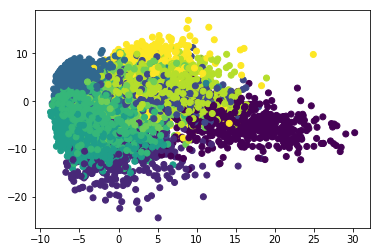

In [13]:
X, Y = load_dataset('mnist')
X = normalize_dataset(X)
for i in range(1):
    C, V, m = sub_kmeans(X, 10)
    Pc = projection_matrices(X.shape[1], m)
    trans = V.T
    X_rotated = MM(trans[None, :, :], np.transpose(X[:, None, :], [0, 2, 1]))
    X_rotated = X_rotated.squeeze(-1).T
    acc = nmi(Y, C)
    # print(acc)
    print(m, acc)
    plt.scatter(X_rotated[0], X_rotated[1], c=C)
    plt.show()

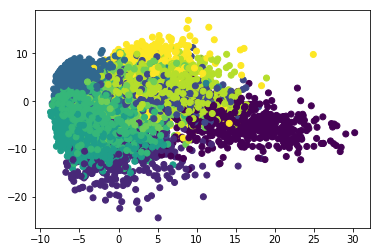

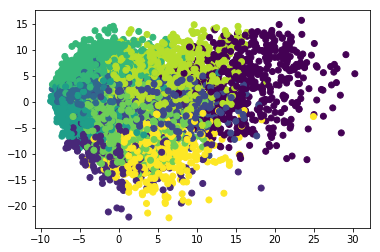

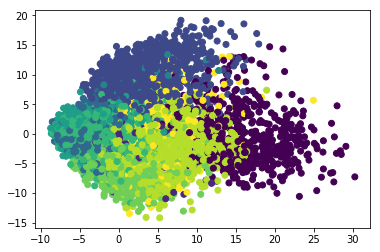

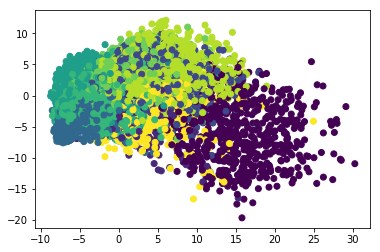

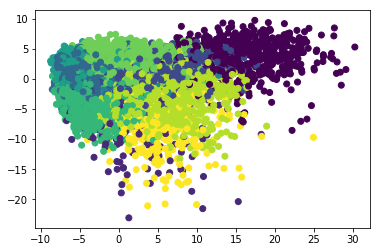

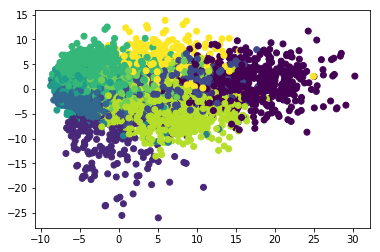

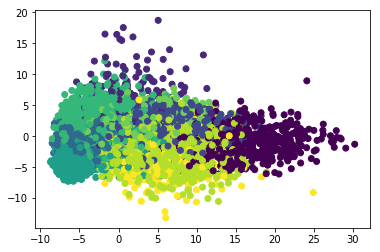

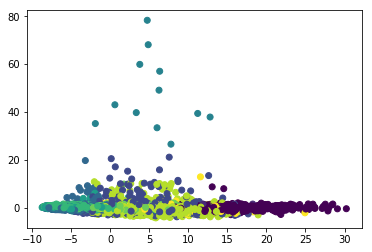

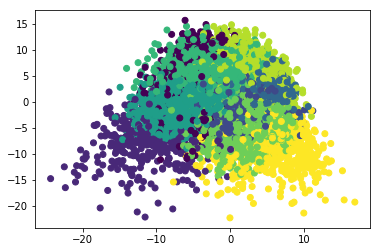

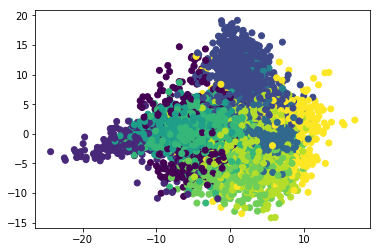

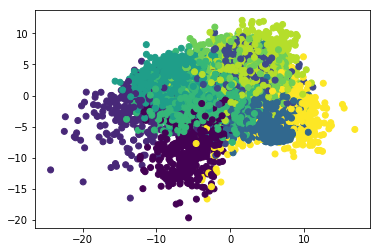

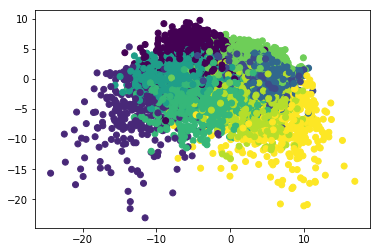

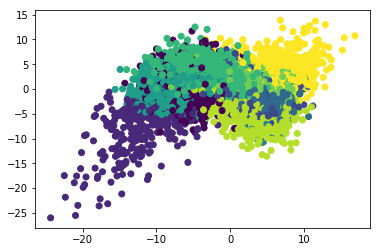

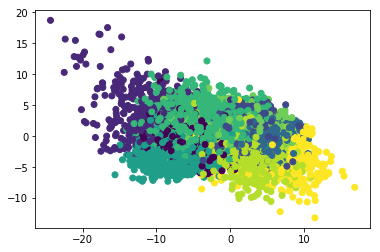

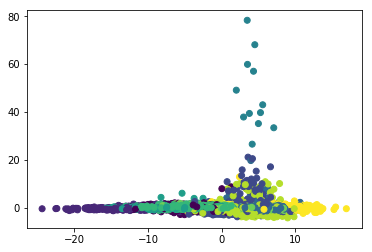

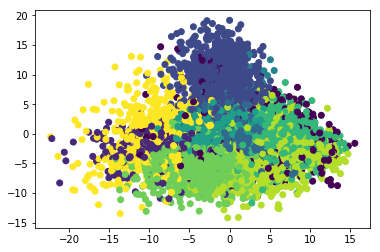

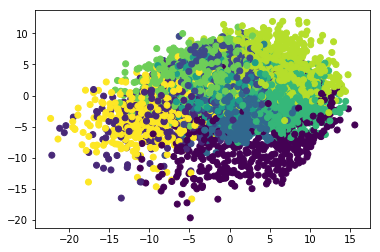

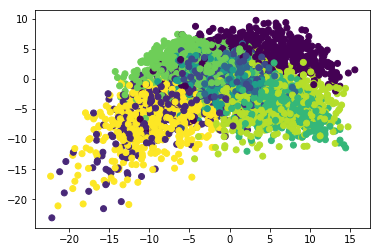

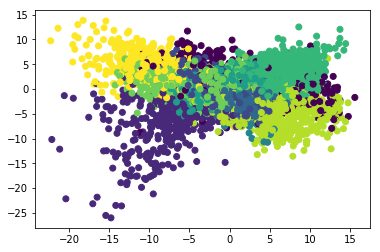

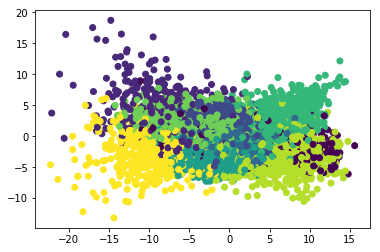

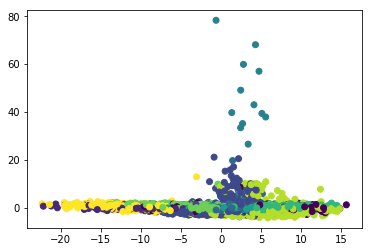

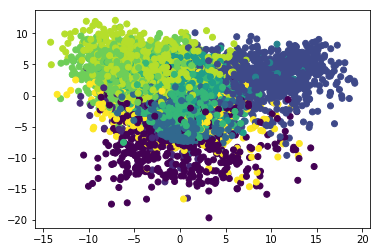

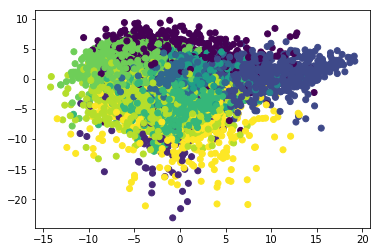

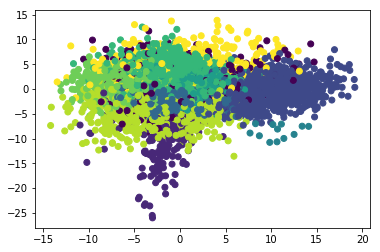

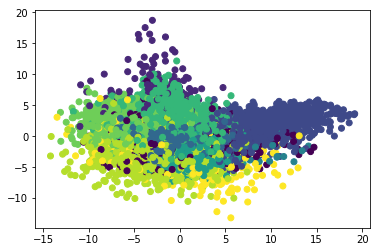

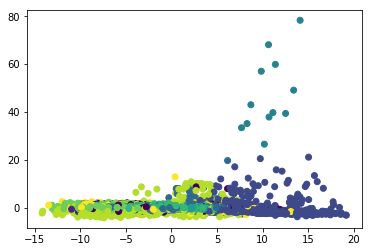

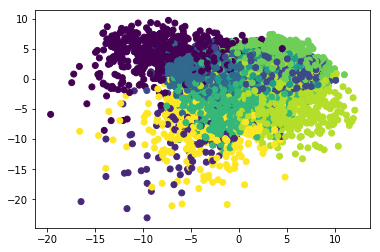

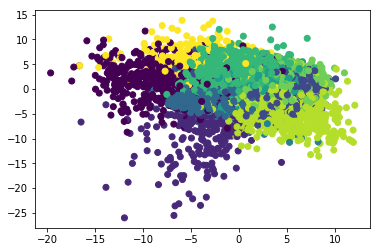

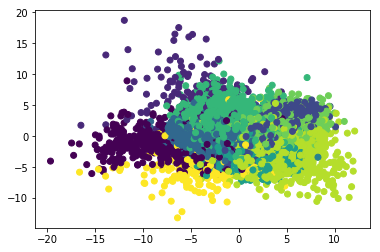

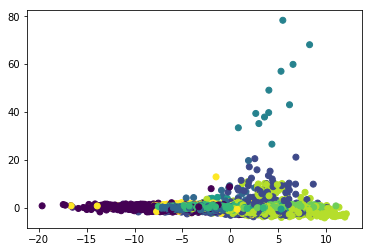

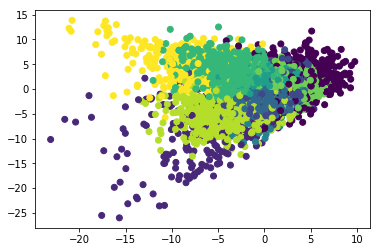

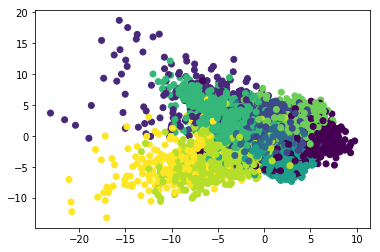

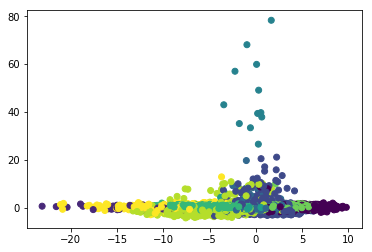

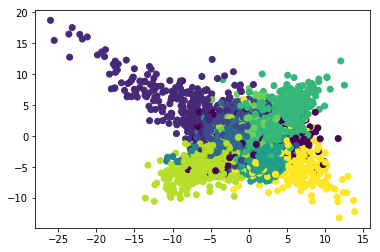

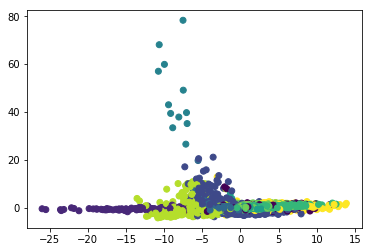

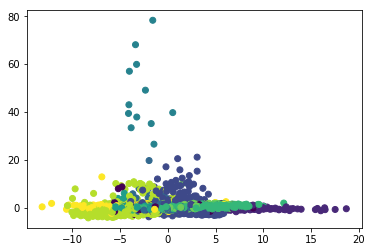

In [17]:
for i in range(9):
    for j in range(i+1, 9):
        plt.scatter(X_rotated[i], X_rotated[j], c=C)
        plt.show()

(784, 784)

In [ ]:
X_rotated.shape

In [ ]:
X_scala = np.loadtxt('/home/abdul/Documents/adm-project/SubKmeans/result/sample_result.dat', delimiter=';')

In [ ]:
X_scala.shape

In [ ]:
C = X_scala[:, 0]
X_scala = X_scala[:, 1:]

In [ ]:
nmi(Y, C)

In [ ]:
plt.scatter(X_scala[:, 0], X_scala[:, 1], c=C)
plt.show()

In [ ]:
C

In [ ]:
X, Y = load_dataset('wine')
X = normalize_dataset(X)


In [ ]:
with open('/home/abdul/Documents/adm-project/SubKmeans/datasets/sample.dat', 'w') as f:
    for i, x in enumerate(X):
        f.write(str(Y[i]))
        f.write(';')
        f.write(';'.join(['%.15f'%j for j in x]))
        f.write('\n')

In [ ]:
def sub_kmeans_loopy(X, k):
    n, d = X.shape
    V = random_V(d)
    m = d/2
    mu_D = np.mean(X, axis=0, keepdims=True)
    S_D = np.zeros([d, d])
    
    Pc = projection_matrices(d, m)
    for e, x in enumerate(X):
        x_minus_muD = (x - mu_D).T
        S_D += MM(x_minus_muD, x_minus_muD.T)
    mu_is = X[np.random.choice(n, k)]
    itr = 0
    while itr < 200:
        C = {i:[] for i in range(k)}
        ass = np.zeros(n, dtype=np.uint8) - 1
        Pc = projection_matrices(d, m)
        trans = MM(Pc.T, V.T)
        for k_num, x in enumerate(X):
            j = -1
            min_dist = 1e10
            for i, mu_i in enumerate(mu_is):
                vec_dist = MM(trans, x[:, None]) -  MM(trans, mu_i[:, None])
                dist = MM(vec_dist.T, vec_dist)[0, 0]
                if dist < min_dist:
                    min_dist = dist
                    j = i
            C[j].append(x)
            ass[k_num] = j
        S = np.zeros([k, d, d])
        for i in range(k):
            X_in_Ci = np.array(C[i])
            mu_is[i] = np.mean(X_in_Ci, axis=0)
            for x in X_in_Ci:
                x_minus_mu_isi = (x - mu_is[i]).T[:, None]
                S[i] += MM(x_minus_mu_isi, x_minus_mu_isi.T)
        sum_S = np.sum(S, axis=0)
        Evals, Evecs = LA.eig((sum_S - S_D))
#         print(Evals.shape)
        idx = np.argsort(Evals)
#         print(Evals.shape)
        V = Evecs[:, idx]
        maxVal = min(Evals)
        if itr > 1:
            m = np.sum([1 for i in Evals if i/maxVal > 1e-8])
            m = max(1, m)
        itr += 1
        ccc = nmi(Y, ass)
    return ass, V, m
        
            

In [ ]:
import tensorflow as tf
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

In [ ]:
data = np.concatenate([mnist.test.labels[:, None], mnist.test.images], axis=1)
np.savetxt('datasets/mnist_dataset.txt', data, delimiter=',', fmt='%.8f')